# Test 2 Response time

In [1]:
import os
import sys


# External dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.formula.api as smf

# Local code from this repository
sys.path.append(os.path.join(os.getcwd(), "..", "code"))
from load_data import load_stimulus, load_all_data, extract_new
from plotting import color_by_reward, color_by_callType, plot_data, set_oddsratio_yticks
from stats import false_discovery, get_odds_ratio_matrix, fisher_exact, jackknife


# The diretory for saving figures - Change to place of your choice
FIGDIR = os.path.expanduser('~/Desktop/')

# The behavioral data is stored in csv files in the data directory
PROJDIR = ".."
DATADIR = "../data/confusion/"
RESULTSDIR = "../results/"

Add or remove WhiHpi in the block below to get data for that bird. We don't have the complete data for this bird. And report both in the paper.

In [2]:
all_df = load_all_data()

# This bird does not have any date for control
all_df = all_df[all_df['bird'] != 'WhiHpi7966F']

# These are three days of interes: the 4v4 day (learning), the congruent 8v8 (control), the inconcruent 4v4+4v4 (confusing)
learning_df = all_df[all_df['day'] == 'learning']
control_df = all_df[all_df['day'] == 'control']
confusing_df = all_df[all_df['day'] == 'confusing']
# naive_df = all_df[all_df['day'] == 'naif']


# add an informative trial column
def inject_ITS(df) :
    Informative_Trials_Seen = []
    for subject in df['bird'].unique() :
        subject_df = df[df['bird'] == subject]
        ITS = 0
        for _,row in subject_df.iterrows():
            Informative_Trials_Seen.append(ITS)
            if row.response == False :
                ITS += 1
    df["Informative Trials Seen"] = Informative_Trials_Seen
    return(df)

learning_df = inject_ITS(learning_df)
control_df = inject_ITS(control_df)
confusing_df = inject_ITS(confusing_df)


birds = all_df['bird'].unique()

/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_49749/702693143.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Informative Trials Seen"] = Informative_Trials_Seen
/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_49749/702693143.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Informative Trials Seen"] = Informative_Trials_Seen
/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_49749/702693143.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [3]:
# Get some statistis on the number of stimuli
Te_vocalizers = all_df.loc[(all_df['Stimulus Call Type'] == 'TE')]['Stimulus Vocalizer'].unique()
print('Number of Te vocalizers', len(Te_vocalizers))
for bird in Te_vocalizers:
    print('\t Vocalizer:', bird, ' # stim', len(all_df.loc[(all_df['Stimulus Call Type'] == 'TE') & (all_df['Stimulus Vocalizer'] == bird)]['stimulus_name'].unique()))
          
print('\t Total', len(all_df.loc[(all_df['Stimulus Call Type'] == 'TE')]['stimulus_name'].unique()))

Th_vocalizers = all_df.loc[(all_df['Stimulus Call Type'] == 'TH')]['Stimulus Vocalizer'].unique()
print('Number of Th vocalizers', len(Th_vocalizers))
for bird in Th_vocalizers:
    print('\t Vocalizer:', bird, ' # stim', len(all_df.loc[(all_df['Stimulus Call Type'] == 'TH') & (all_df['Stimulus Vocalizer'] == bird)]['stimulus_name'].unique()))
          
print('\t Total', len(all_df.loc[(all_df['Stimulus Call Type'] == 'TH')]['stimulus_name'].unique()))

DC_vocalizers = all_df.loc[(all_df['Stimulus Call Type'] == 'DC')]['Stimulus Vocalizer'].unique()
print('Number of DC vocalizers', len(DC_vocalizers))
for bird in DC_vocalizers:
    print('\t Vocalizer:', bird, ' # stim', len(all_df.loc[(all_df['Stimulus Call Type'] == 'DC') & (all_df['Stimulus Vocalizer'] == bird)]['stimulus_name'].unique()))
          
print('\t Total', len(all_df.loc[(all_df['Stimulus Call Type'] == 'DC')]['stimulus_name'].unique()))

print('Total', len(all_df['stimulus_name'].unique()))

Number of Te vocalizers 12
	 Vocalizer: BluRas07dd  # stim 77
	 Vocalizer: BlaLbl8026  # stim 109
	 Vocalizer: GreOra1817  # stim 69
	 Vocalizer: WhiGra0114  # stim 79
	 Vocalizer: WhiBlu4818  # stim 218
	 Vocalizer: WhiWhi1415  # stim 78
	 Vocalizer: WhiLbl0010  # stim 136
	 Vocalizer: WhiBlu5698  # stim 109
	 Vocalizer: GraGra0201  # stim 71
	 Vocalizer: PurRas20dd  # stim 140
	 Vocalizer: LblRed0613  # stim 139
	 Vocalizer: GreWhi1242  # stim 140
	 Total 1365
Number of Th vocalizers 12
	 Vocalizer: GreOra1817  # stim 116
	 Vocalizer: GraGra0201  # stim 117
	 Vocalizer: WhiWhi1415  # stim 60
	 Vocalizer: WhiBlu4917  # stim 60
	 Vocalizer: HPiHPi4748  # stim 146
	 Vocalizer: BlaBla0506  # stim 116
	 Vocalizer: WhiGra0114  # stim 60
	 Vocalizer: WhiRas44dd  # stim 60
	 Vocalizer: LblRed0613  # stim 30
	 Vocalizer: WhiBlu5698  # stim 26
	 Vocalizer: WhiBlu4818  # stim 28
	 Vocalizer: Unknown000  # stim 27
	 Total 846
Number of DC vocalizers 12
	 Vocalizer: BlaBla0506  # stim 100
	 Vocal

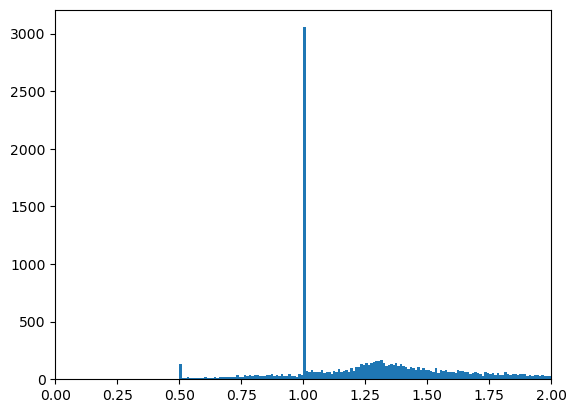

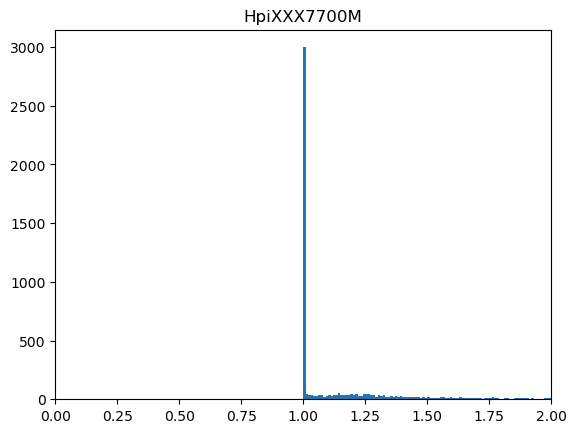

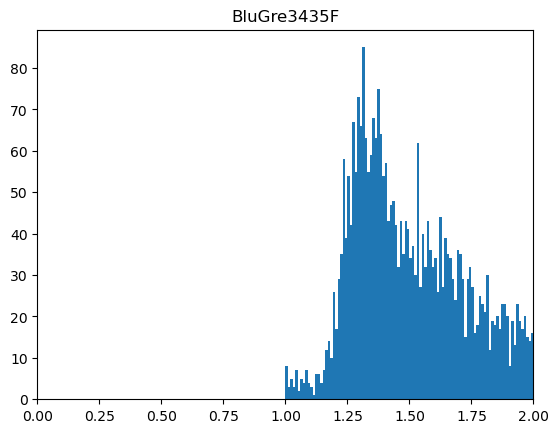

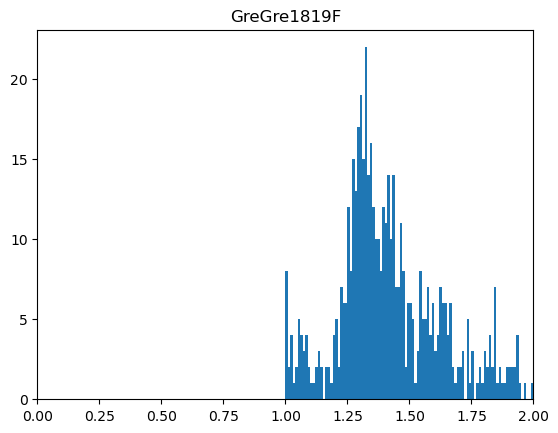

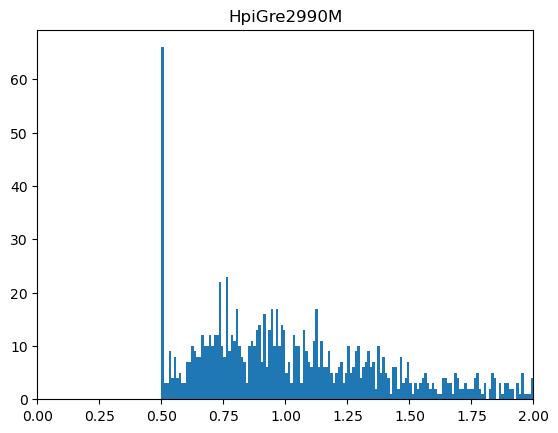

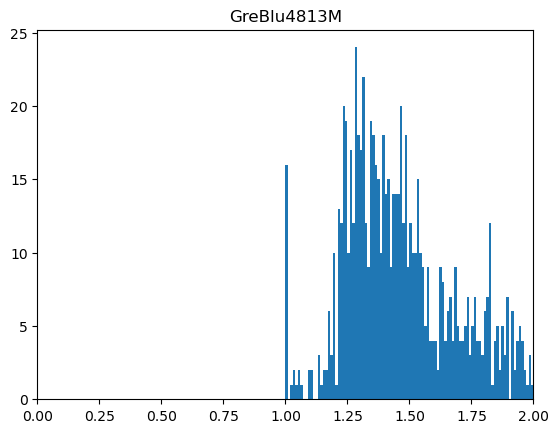

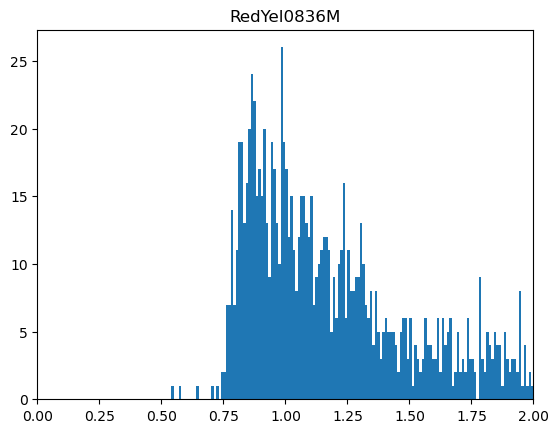

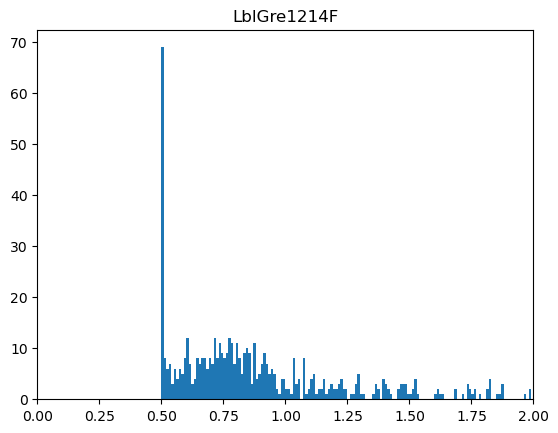

In [4]:
plt.hist((pd.to_timedelta(all_df['rt']).array).total_seconds(), bins=600, range = (0,6.0))
plt.xlim((0, 2.0))
plt.show()

# Repeat per bird
birds = all_df['bird'].unique()
for bird in birds:
    df_bird = all_df.loc[all_df['bird'] == bird]
    plt.hist((pd.to_timedelta(df_bird['rt']).array).total_seconds(), bins=600, range = (0,6.0))
    plt.xlim((0, 2.0))
    plt.title(bird)
    plt.show()

In [5]:
# Get the old and new vocalizers.  This code assumes that all birds had the same training

new_vocalizers_confusing_TEvsDC = confusing_df.loc[ (confusing_df['Stimulus Call Type'] == 'TE') & (confusing_df['bol_Confusing'] & (confusing_df['test'] == 'DCvsTET')), 'Stimulus Vocalizer'].unique()
new_vocalizers_confusing_TEvsTH = confusing_df.loc[ (confusing_df['Stimulus Call Type'] == 'TE') & (confusing_df['bol_Confusing'] & (confusing_df['test'] == 'THvsTET')), 'Stimulus Vocalizer'].unique()
new_vocalizers_confusing_TH = confusing_df.loc[ (confusing_df['Stimulus Call Type'] == 'TH') & (confusing_df['bol_Confusing']), 'Stimulus Vocalizer'].unique()
new_vocalizers_confusing_DC = confusing_df.loc[ (confusing_df['Stimulus Call Type'] == 'DC') & (confusing_df['bol_Confusing']), 'Stimulus Vocalizer'].unique()

old_vocalizers_confusing_TEvsDC = confusing_df.loc[ (confusing_df['Stimulus Call Type'] == 'TE') & (confusing_df['bol_Confusing'] == False) & (confusing_df['test'] == 'DCvsTET'), 'Stimulus Vocalizer'].unique()
old_vocalizers_confusing_TEvsTH = confusing_df.loc[ (confusing_df['Stimulus Call Type'] == 'TE') & (confusing_df['bol_Confusing'] == False) & (confusing_df['test'] == 'THvsTET'), 'Stimulus Vocalizer'].unique()
old_vocalizers_confusing_TH = confusing_df.loc[ (confusing_df['Stimulus Call Type'] == 'TH') & (confusing_df['bol_Confusing'] == False), 'Stimulus Vocalizer'].unique()
old_vocalizers_confusing_DC = confusing_df.loc[ (confusing_df['Stimulus Call Type'] == 'DC') & (confusing_df['bol_Confusing'] == False), 'Stimulus Vocalizer'].unique()

old_vocalizers_control_TEvsDC = learning_df.loc[ (learning_df['Stimulus Call Type'] == 'TE') & (learning_df['test'] == 'DCvsTET') , 'Stimulus Vocalizer'].unique()
old_vocalizers_control_TEvsTH = learning_df.loc[ (learning_df['Stimulus Call Type'] == 'TE') & (learning_df['test'] == 'THvsTET') , 'Stimulus Vocalizer'].unique()
old_vocalizers_control_TH = learning_df.loc[ (learning_df['Stimulus Call Type'] == 'TH'), 'Stimulus Vocalizer'].unique()
old_vocalizers_control_DC = learning_df.loc[ (learning_df['Stimulus Call Type'] == 'DC'), 'Stimulus Vocalizer'].unique()

all_vocalizers_control_TEvsDC = control_df.loc[ (control_df['Stimulus Call Type'] == 'TE') & (control_df['test'] == 'DCvsTET'), 'Stimulus Vocalizer'].unique()
all_vocalizers_control_TEvsTH = control_df.loc[ (control_df['Stimulus Call Type'] == 'TE') & (control_df['test'] == 'THvsTET'), 'Stimulus Vocalizer'].unique()
all_vocalizers_control_TH = control_df.loc[ (control_df['Stimulus Call Type'] == 'TH'), 'Stimulus Vocalizer'].unique()
all_vocalizers_control_DC = control_df.loc[ (control_df['Stimulus Call Type'] == 'DC'), 'Stimulus Vocalizer'].unique()

new_vocalizers_control_TEvsDC = list(set(all_vocalizers_control_TEvsDC) - set(old_vocalizers_control_TEvsDC) )
new_vocalizers_control_TEvsTH = list(set(all_vocalizers_control_TEvsTH) - set(old_vocalizers_control_TEvsTH) )
new_vocalizers_control_TH = list(set(all_vocalizers_control_TH) - set(old_vocalizers_control_TH) )
new_vocalizers_control_DC = list(set(all_vocalizers_control_DC) - set(old_vocalizers_control_DC) )



In [6]:
# Checking that old are the same in controls and confusing and that new are different.
# This output is used in extract_new which is in load_data.py
print('TE in TE vs DC:')
print('\t old - controls:', old_vocalizers_control_TEvsDC)
print('\t old - confusing:', old_vocalizers_confusing_TEvsDC)
print('\t new - controls:', new_vocalizers_control_TEvsDC)
print('\t new - confusing:', new_vocalizers_confusing_TEvsDC)

print('TE in TE vs TH:')
print('\t old - controls:', old_vocalizers_control_TEvsTH)
print('\t old - confusing:', old_vocalizers_confusing_TEvsTH)
print('\t new - controls:', new_vocalizers_control_TEvsTH)
print('\t new - confusing:', new_vocalizers_confusing_TEvsTH)

print('TH:')
print('\t old - controls:', old_vocalizers_control_TH)
print('\t old - confusing:', old_vocalizers_confusing_TH)
print('\t new - controls:', new_vocalizers_control_TH)
print('\t new - confusing:', new_vocalizers_confusing_TH)

print('DC:')
print('\t old - controls:', old_vocalizers_control_DC)
print('\t old - confusing:', old_vocalizers_confusing_DC)
print('\t new - controls:', new_vocalizers_control_DC)
print('\t new - confusing:', new_vocalizers_confusing_DC)

TE in TE vs DC:
	 old - controls: ['WhiBlu5698' 'WhiBlu4818' 'WhiLbl0010' 'BlaLbl8026']
	 old - confusing: ['WhiBlu5698' 'WhiBlu4818' 'WhiLbl0010' 'BlaLbl8026']
	 new - controls: ['LblRed0613', 'GraGra0201', 'GreWhi1242', 'PurRas20dd']
	 new - confusing: ['WhiGra0114' 'BluRas07dd' 'GreOra1817' 'WhiWhi1415']
TE in TE vs TH:
	 old - controls: ['PurRas20dd' 'GreWhi1242' 'WhiBlu4818' 'LblRed0613']
	 old - confusing: ['PurRas20dd' 'WhiBlu4818' 'GreWhi1242' 'LblRed0613']
	 new - controls: ['WhiBlu5698', 'WhiLbl0010', 'BlaLbl8026', 'GreOra1817']
	 new - confusing: ['WhiGra0114' 'GraGra0201' 'WhiWhi1415' 'BluRas07dd']
TH:
	 old - controls: ['GreOra1817' 'HPiHPi4748' 'BlaBla0506' 'GraGra0201']
	 old - confusing: ['GreOra1817' 'BlaBla0506' 'HPiHPi4748' 'GraGra0201']
	 new - controls: ['LblRed0613', 'WhiBlu4818', 'WhiBlu5698', 'Unknown000']
	 new - confusing: ['WhiRas44dd' 'WhiGra0114' 'WhiWhi1415' 'WhiBlu4917']
DC:
	 old - controls: ['YelGre5275' 'BlaLbl8026' 'BlaBla0506' 'WhiBlu4917']
	 old - c

In [7]:
print('Call type tested:', all_df['Stimulus Call Type'].unique())
print('Day types;', all_df['day'].unique())

Call type tested: ['TE' 'DC' 'TH']
Day types; ['return-to-normal' 'control' 'confusing' 'learning' 'naif']


### Get color and marker code

In [8]:
color_by_call = {
    'TE' : '#9BCD9B',
    'DC' : 'lightseagreen',
    'TH' : 'tan',
    'old' : '#9bcd7b',
    'new' : '#80b1d3',
    'THvsTET' : '#9BCD9B',
    'DCvsTET' : 'lightseagreen'
}

test_marker_code = {
    'THvsTET' : 'o',
    'DCvsTET' : 'd',
    'old' : 'X',
    'new' : 'o'
}

marker_by_test = {
    'DCvsTET' : 'o' ,
    'THvsTET' : 'x' ,
    'old' : 'x',
    'new' : 'o'
}


# Plotting a non congruent day 

## Example data from one subject

Individual lines show probability of interruption for individual vocalizers in 20-trial bins (blue: rewarded, red: non-rewarded). Tick marks above the plot indicate interrupted trials and tick marks below the plot indicate non-interrupted trials.

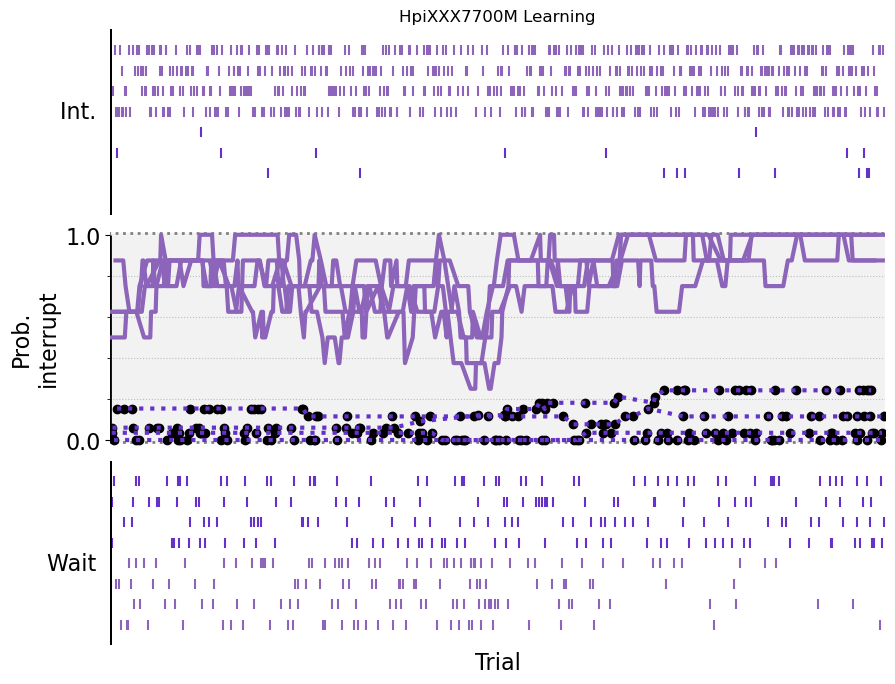

HpiXXX7700M  Learning: 
	 Groups: 8 dict_keys([('Rewarded', 'BlaBla0506', 'DC'), ('Rewarded', 'BlaLbl8026', 'DC'), ('Rewarded', 'WhiBlu4917', 'DC'), ('Rewarded', 'YelGre5275', 'DC'), ('Unrewarded', 'BlaLbl8026', 'TE'), ('Unrewarded', 'WhiBlu4818', 'TE'), ('Unrewarded', 'WhiBlu5698', 'TE'), ('Unrewarded', 'WhiLbl0010', 'TE')])


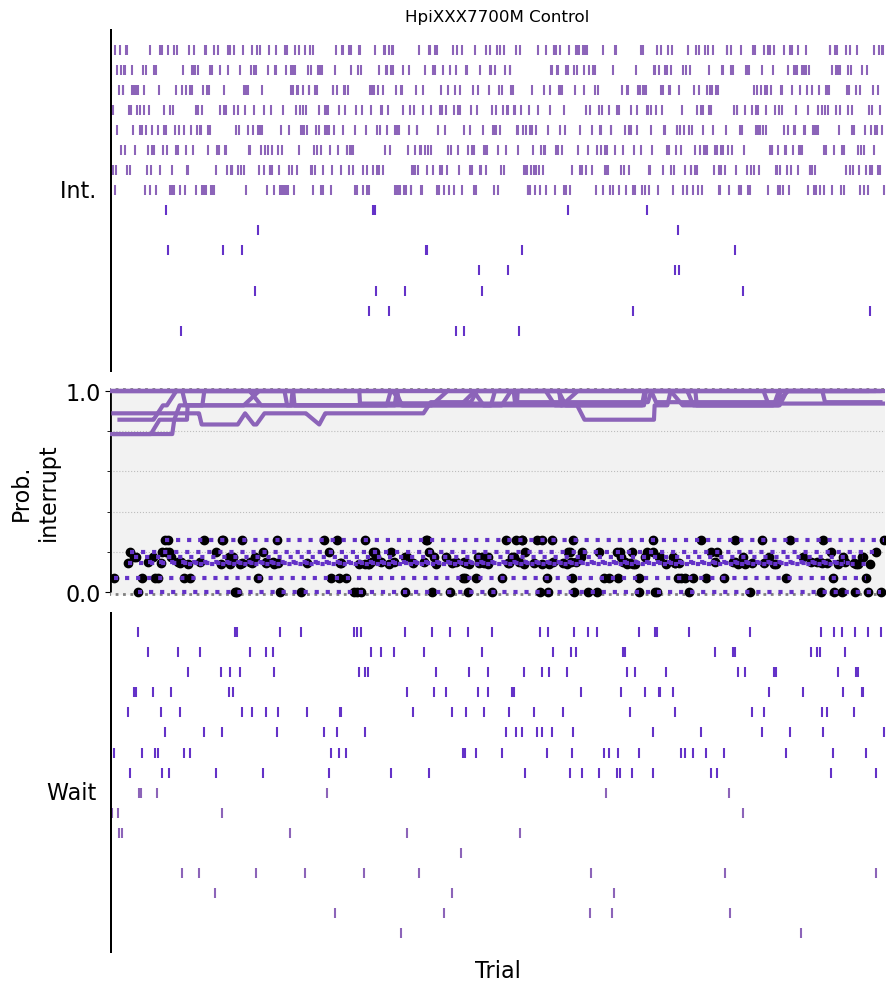

HpiXXX7700M  Control: 
	 Groups: 16 dict_keys([('Rewarded', 'BlaBla0506', 'DC'), ('Rewarded', 'BlaLbl8026', 'DC'), ('Rewarded', 'LblBla4548', 'DC'), ('Rewarded', 'LblRed0613', 'DC'), ('Rewarded', 'WhiBlu4818', 'DC'), ('Rewarded', 'WhiBlu4917', 'DC'), ('Rewarded', 'WhiWhi1415', 'DC'), ('Rewarded', 'YelGre5275', 'DC'), ('Unrewarded', 'BlaLbl8026', 'TE'), ('Unrewarded', 'GraGra0201', 'TE'), ('Unrewarded', 'GreWhi1242', 'TE'), ('Unrewarded', 'LblRed0613', 'TE'), ('Unrewarded', 'PurRas20dd', 'TE'), ('Unrewarded', 'WhiBlu4818', 'TE'), ('Unrewarded', 'WhiBlu5698', 'TE'), ('Unrewarded', 'WhiLbl0010', 'TE')])


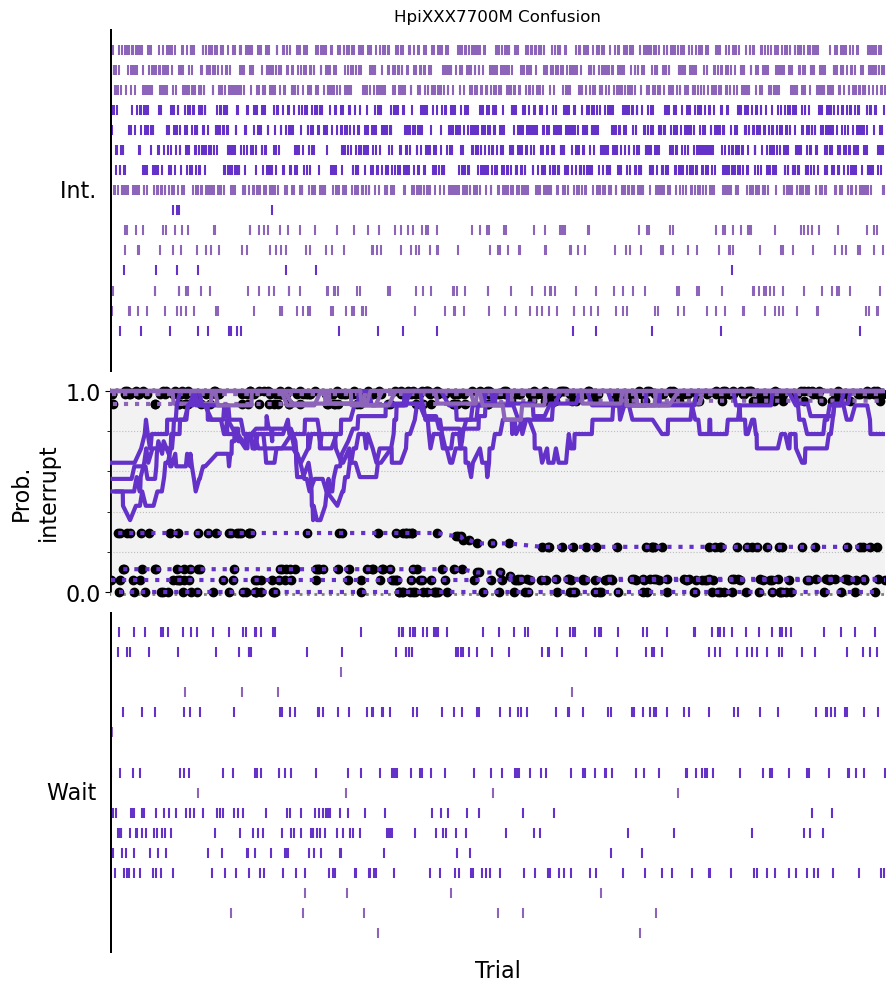

HpiXXX7700M  Confusion: 
	 Groups: 16 dict_keys([('Rewarded', 'BlaBla0506', 'DC'), ('Rewarded', 'BlaLbl8026', 'DC'), ('Rewarded', 'BluRas07dd', 'TE'), ('Rewarded', 'GreOra1817', 'TE'), ('Rewarded', 'WhiBlu4917', 'DC'), ('Rewarded', 'WhiGra0114', 'TE'), ('Rewarded', 'WhiWhi1415', 'TE'), ('Rewarded', 'YelGre5275', 'DC'), ('Unrewarded', 'BlaLbl8026', 'TE'), ('Unrewarded', 'GraGra0201', 'DC'), ('Unrewarded', 'PurRas20dd', 'DC'), ('Unrewarded', 'RedRas3600', 'DC'), ('Unrewarded', 'Unknown00F', 'DC'), ('Unrewarded', 'WhiBlu4818', 'TE'), ('Unrewarded', 'WhiBlu5698', 'TE'), ('Unrewarded', 'WhiLbl0010', 'TE')])


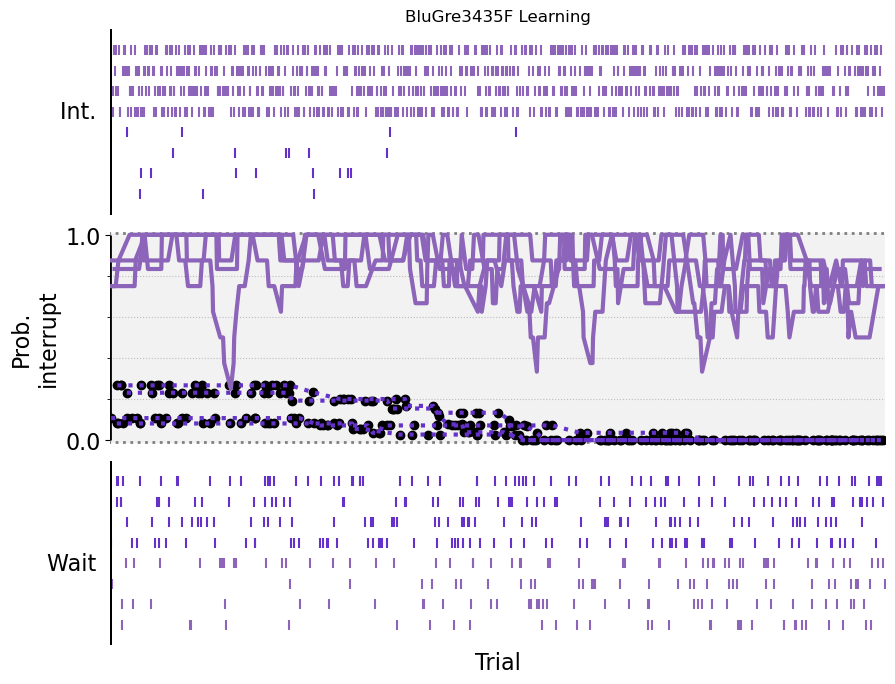

BluGre3435F  Learning: 
	 Groups: 8 dict_keys([('Rewarded', 'BlaBla0506', 'DC'), ('Rewarded', 'BlaLbl8026', 'DC'), ('Rewarded', 'WhiBlu4917', 'DC'), ('Rewarded', 'YelGre5275', 'DC'), ('Unrewarded', 'BlaLbl8026', 'TE'), ('Unrewarded', 'WhiBlu4818', 'TE'), ('Unrewarded', 'WhiBlu5698', 'TE'), ('Unrewarded', 'WhiLbl0010', 'TE')])


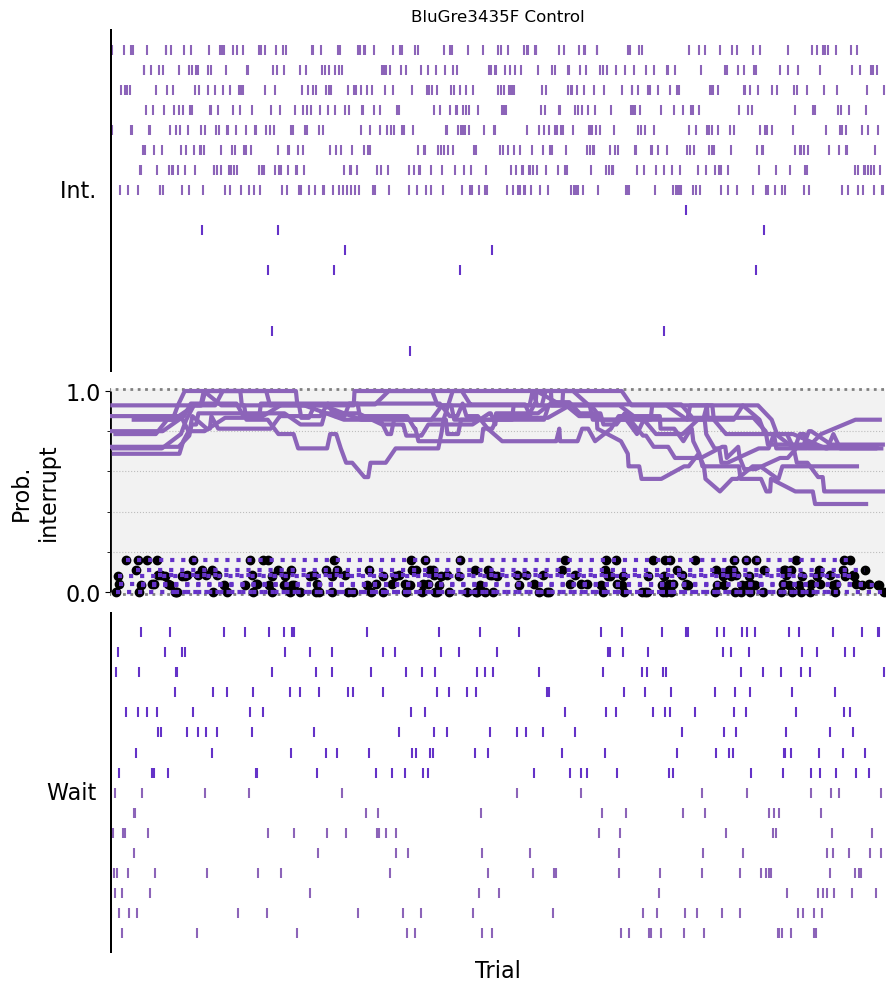

BluGre3435F  Control: 
	 Groups: 16 dict_keys([('Rewarded', 'BlaBla0506', 'DC'), ('Rewarded', 'BlaLbl8026', 'DC'), ('Rewarded', 'LblBla4548', 'DC'), ('Rewarded', 'LblRed0613', 'DC'), ('Rewarded', 'WhiBlu4818', 'DC'), ('Rewarded', 'WhiBlu4917', 'DC'), ('Rewarded', 'WhiWhi1415', 'DC'), ('Rewarded', 'YelGre5275', 'DC'), ('Unrewarded', 'BlaLbl8026', 'TE'), ('Unrewarded', 'GraGra0201', 'TE'), ('Unrewarded', 'GreWhi1242', 'TE'), ('Unrewarded', 'LblRed0613', 'TE'), ('Unrewarded', 'PurRas20dd', 'TE'), ('Unrewarded', 'WhiBlu4818', 'TE'), ('Unrewarded', 'WhiBlu5698', 'TE'), ('Unrewarded', 'WhiLbl0010', 'TE')])


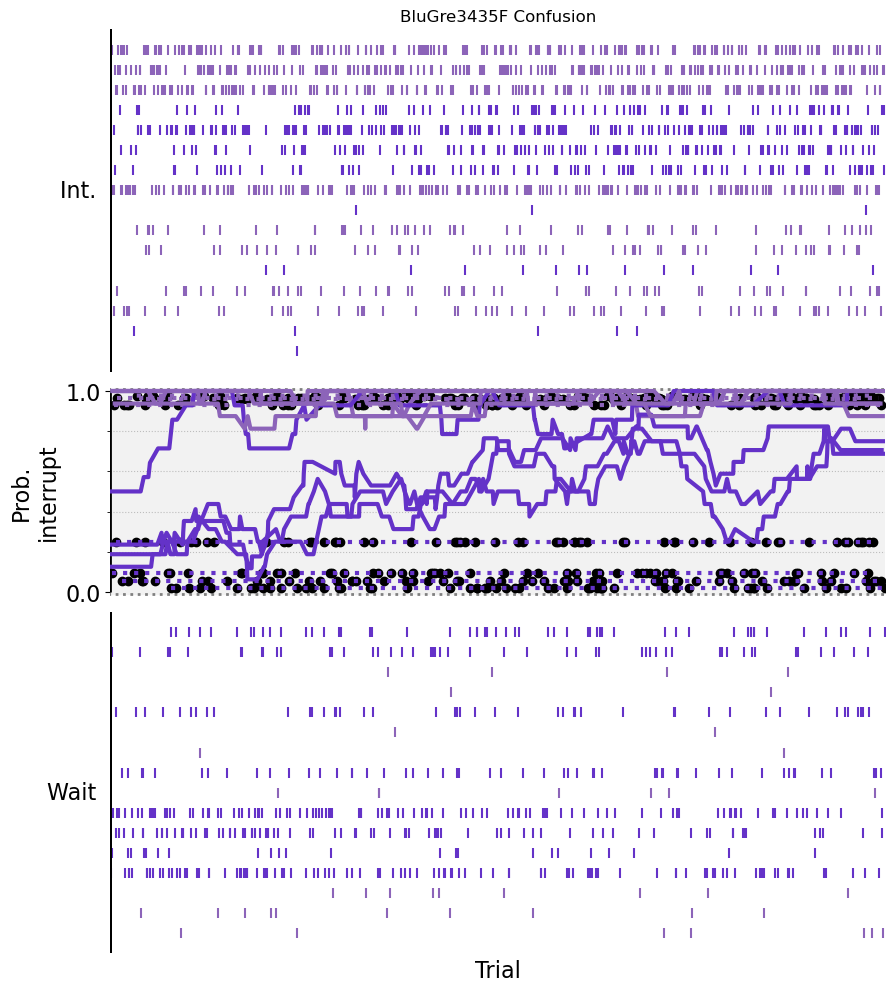

BluGre3435F  Confusion: 
	 Groups: 16 dict_keys([('Rewarded', 'BlaBla0506', 'DC'), ('Rewarded', 'BlaLbl8026', 'DC'), ('Rewarded', 'BluRas07dd', 'TE'), ('Rewarded', 'GreOra1817', 'TE'), ('Rewarded', 'WhiBlu4917', 'DC'), ('Rewarded', 'WhiGra0114', 'TE'), ('Rewarded', 'WhiWhi1415', 'TE'), ('Rewarded', 'YelGre5275', 'DC'), ('Unrewarded', 'BlaLbl8026', 'TE'), ('Unrewarded', 'GraGra0201', 'DC'), ('Unrewarded', 'PurRas20dd', 'DC'), ('Unrewarded', 'RedRas3600', 'DC'), ('Unrewarded', 'Unknown00F', 'DC'), ('Unrewarded', 'WhiBlu4818', 'TE'), ('Unrewarded', 'WhiBlu5698', 'TE'), ('Unrewarded', 'WhiLbl0010', 'TE')])


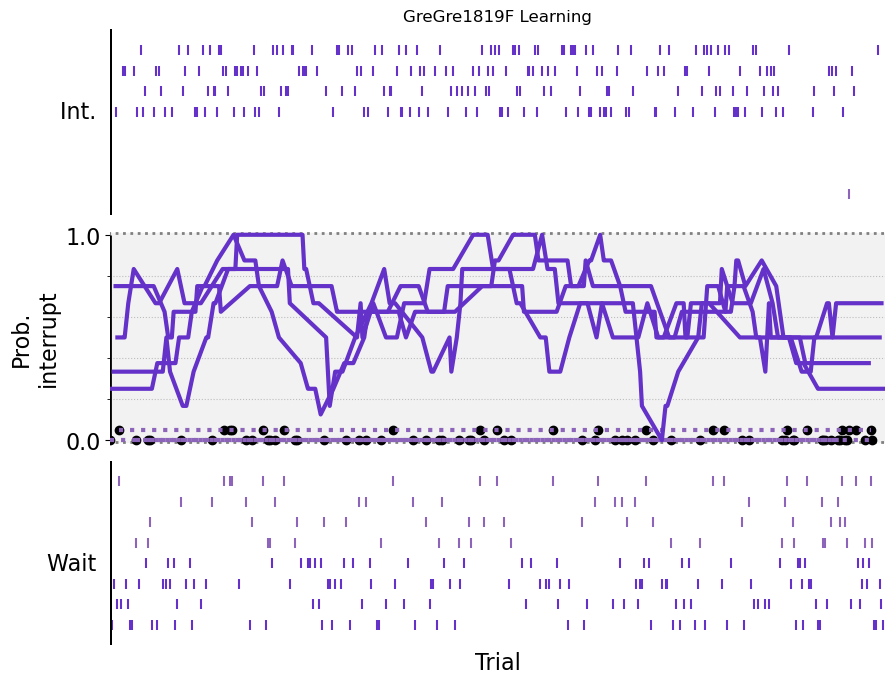

GreGre1819F  Learning: 
	 Groups: 8 dict_keys([('Rewarded', 'BlaLbl8026', 'TE'), ('Rewarded', 'WhiBlu4818', 'TE'), ('Rewarded', 'WhiBlu5698', 'TE'), ('Rewarded', 'WhiLbl0010', 'TE'), ('Unrewarded', 'BlaBla0506', 'DC'), ('Unrewarded', 'BlaLbl8026', 'DC'), ('Unrewarded', 'WhiBlu4917', 'DC'), ('Unrewarded', 'YelGre5275', 'DC')])


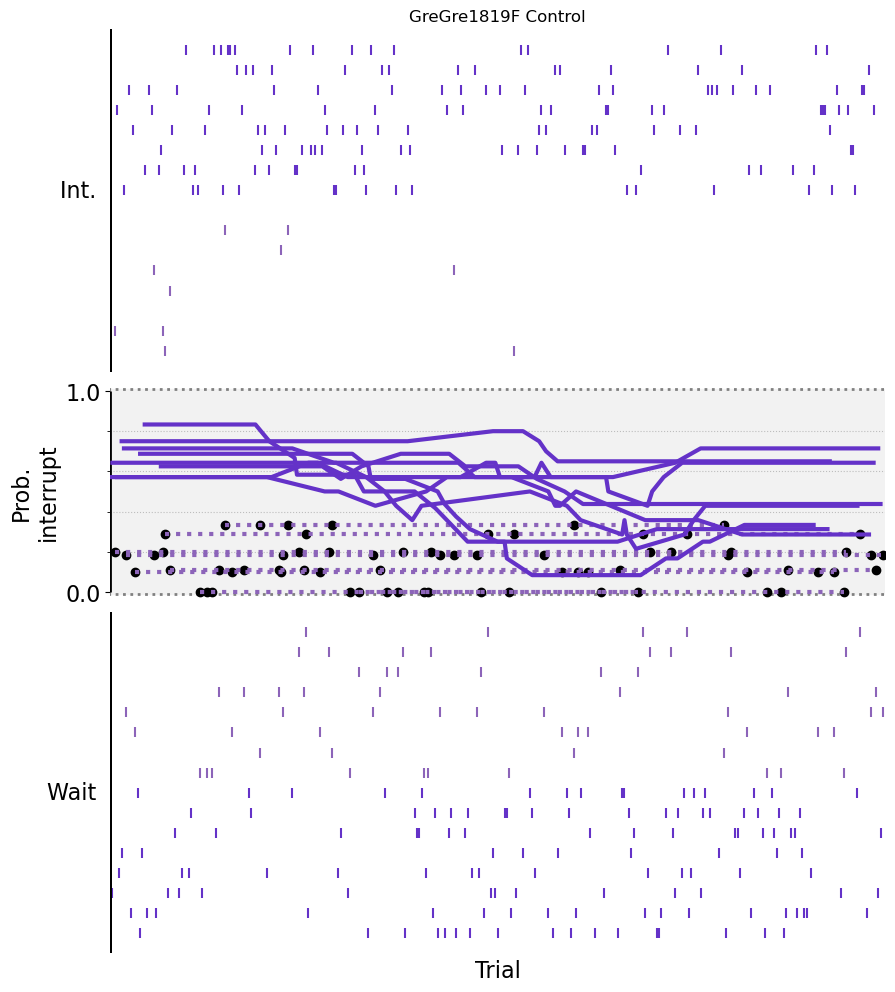

GreGre1819F  Control: 
	 Groups: 16 dict_keys([('Rewarded', 'BlaLbl8026', 'TE'), ('Rewarded', 'GraGra0201', 'TE'), ('Rewarded', 'GreWhi1242', 'TE'), ('Rewarded', 'LblRed0613', 'TE'), ('Rewarded', 'PurRas20dd', 'TE'), ('Rewarded', 'WhiBlu4818', 'TE'), ('Rewarded', 'WhiBlu5698', 'TE'), ('Rewarded', 'WhiLbl0010', 'TE'), ('Unrewarded', 'BlaBla0506', 'DC'), ('Unrewarded', 'BlaLbl8026', 'DC'), ('Unrewarded', 'LblBla4548', 'DC'), ('Unrewarded', 'LblRed0613', 'DC'), ('Unrewarded', 'WhiBlu4818', 'DC'), ('Unrewarded', 'WhiBlu4917', 'DC'), ('Unrewarded', 'WhiWhi1415', 'DC'), ('Unrewarded', 'YelGre5275', 'DC')])


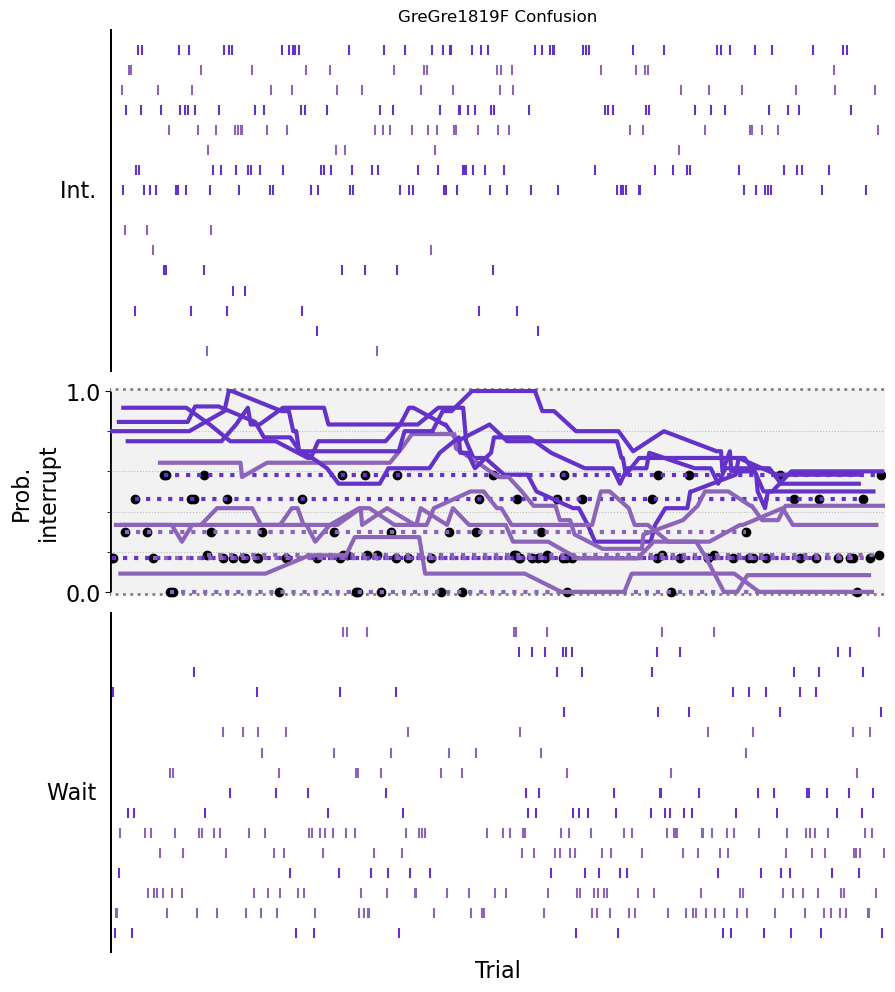

GreGre1819F  Confusion: 
	 Groups: 16 dict_keys([('Rewarded', 'BlaLbl8026', 'TE'), ('Rewarded', 'GraGra0201', 'DC'), ('Rewarded', 'PurRas20dd', 'DC'), ('Rewarded', 'RedRas3600', 'DC'), ('Rewarded', 'Unknown00F', 'DC'), ('Rewarded', 'WhiBlu4818', 'TE'), ('Rewarded', 'WhiBlu5698', 'TE'), ('Rewarded', 'WhiLbl0010', 'TE'), ('Unrewarded', 'BlaBla0506', 'DC'), ('Unrewarded', 'BlaLbl8026', 'DC'), ('Unrewarded', 'BluRas07dd', 'TE'), ('Unrewarded', 'GreOra1817', 'TE'), ('Unrewarded', 'WhiBlu4917', 'DC'), ('Unrewarded', 'WhiGra0114', 'TE'), ('Unrewarded', 'WhiWhi1415', 'TE'), ('Unrewarded', 'YelGre5275', 'DC')])


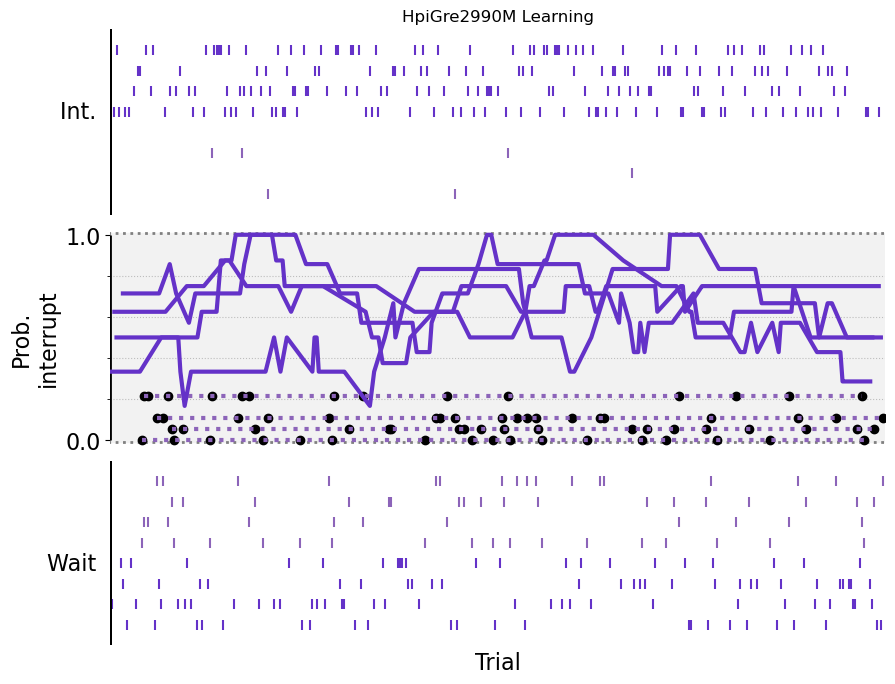

HpiGre2990M  Learning: 
	 Groups: 8 dict_keys([('Rewarded', 'BlaLbl8026', 'TE'), ('Rewarded', 'WhiBlu4818', 'TE'), ('Rewarded', 'WhiBlu5698', 'TE'), ('Rewarded', 'WhiLbl0010', 'TE'), ('Unrewarded', 'BlaBla0506', 'DC'), ('Unrewarded', 'BlaLbl8026', 'DC'), ('Unrewarded', 'WhiBlu4917', 'DC'), ('Unrewarded', 'YelGre5275', 'DC')])


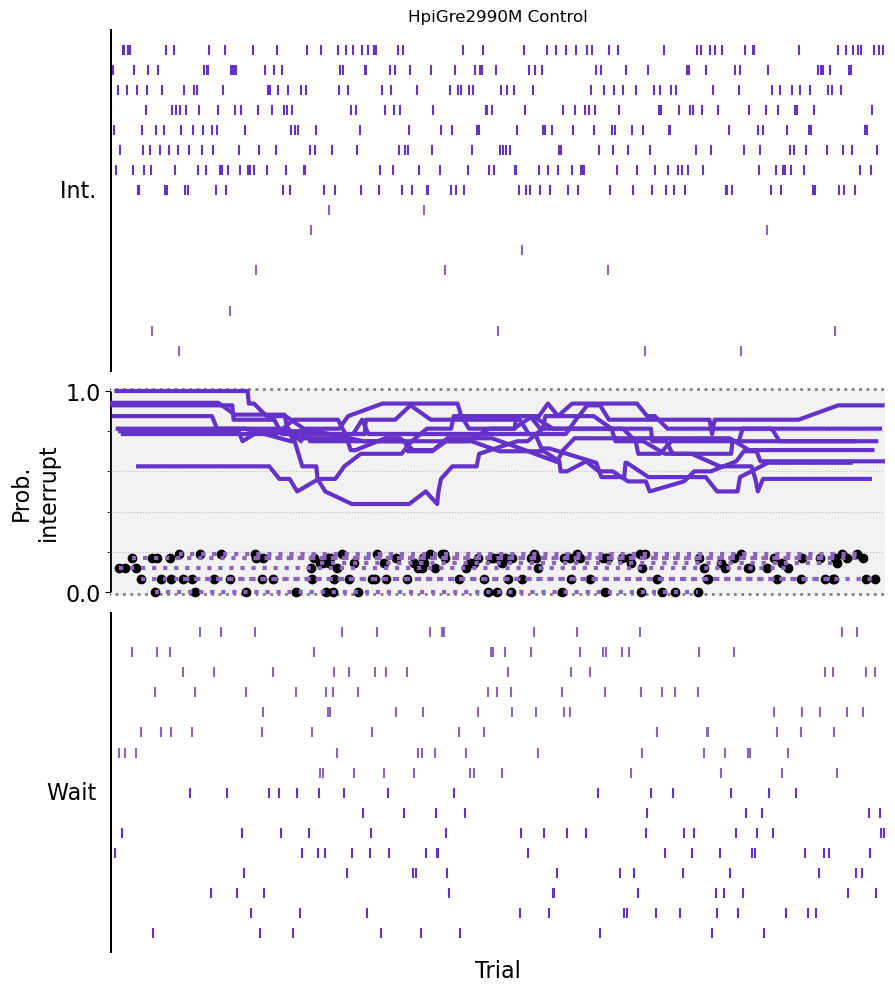

HpiGre2990M  Control: 
	 Groups: 16 dict_keys([('Rewarded', 'BlaLbl8026', 'TE'), ('Rewarded', 'GraGra0201', 'TE'), ('Rewarded', 'GreWhi1242', 'TE'), ('Rewarded', 'LblRed0613', 'TE'), ('Rewarded', 'PurRas20dd', 'TE'), ('Rewarded', 'WhiBlu4818', 'TE'), ('Rewarded', 'WhiBlu5698', 'TE'), ('Rewarded', 'WhiLbl0010', 'TE'), ('Unrewarded', 'BlaBla0506', 'DC'), ('Unrewarded', 'BlaLbl8026', 'DC'), ('Unrewarded', 'LblBla4548', 'DC'), ('Unrewarded', 'LblRed0613', 'DC'), ('Unrewarded', 'WhiBlu4818', 'DC'), ('Unrewarded', 'WhiBlu4917', 'DC'), ('Unrewarded', 'WhiWhi1415', 'DC'), ('Unrewarded', 'YelGre5275', 'DC')])


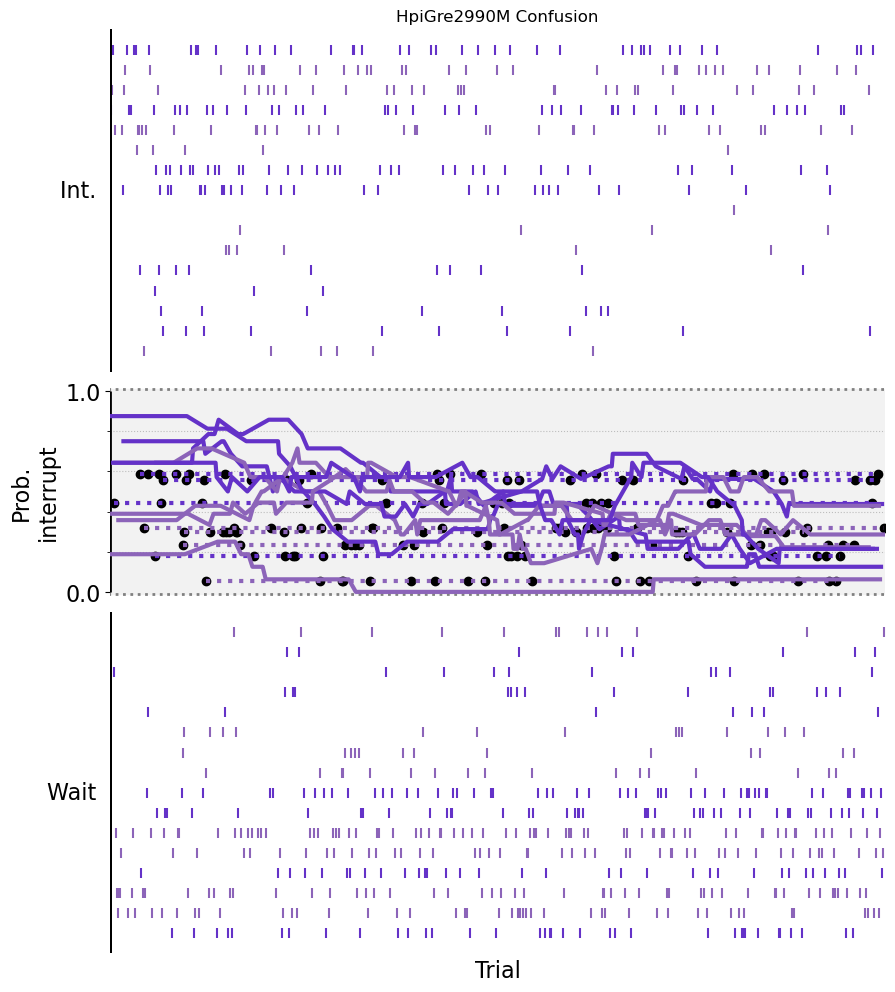

HpiGre2990M  Confusion: 
	 Groups: 16 dict_keys([('Rewarded', 'BlaLbl8026', 'TE'), ('Rewarded', 'GraGra0201', 'DC'), ('Rewarded', 'PurRas20dd', 'DC'), ('Rewarded', 'RedRas3600', 'DC'), ('Rewarded', 'Unknown00F', 'DC'), ('Rewarded', 'WhiBlu4818', 'TE'), ('Rewarded', 'WhiBlu5698', 'TE'), ('Rewarded', 'WhiLbl0010', 'TE'), ('Unrewarded', 'BlaBla0506', 'DC'), ('Unrewarded', 'BlaLbl8026', 'DC'), ('Unrewarded', 'BluRas07dd', 'TE'), ('Unrewarded', 'GreOra1817', 'TE'), ('Unrewarded', 'WhiBlu4917', 'DC'), ('Unrewarded', 'WhiGra0114', 'TE'), ('Unrewarded', 'WhiWhi1415', 'TE'), ('Unrewarded', 'YelGre5275', 'DC')])


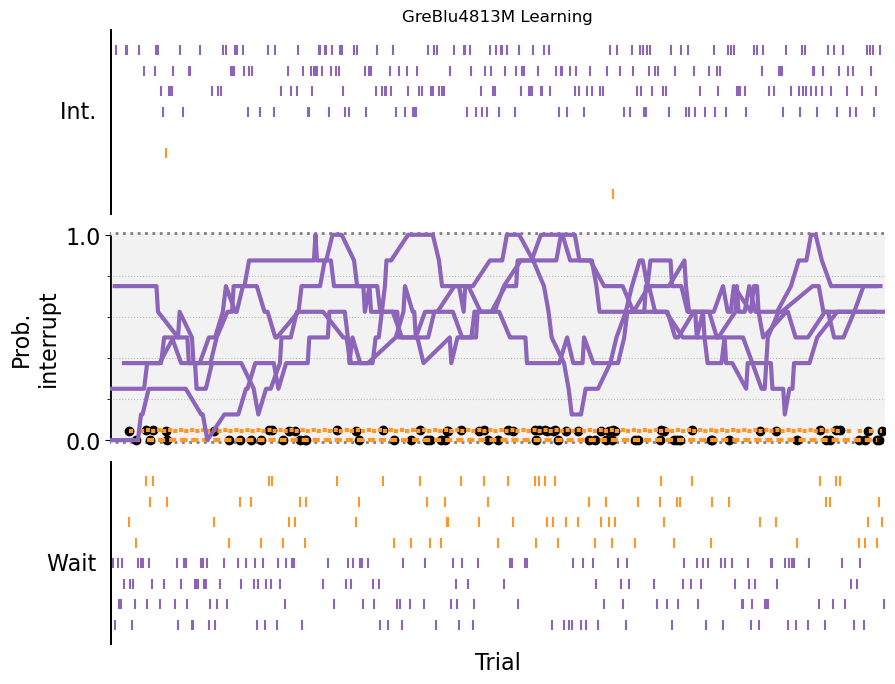

GreBlu4813M  Learning: 
	 Groups: 8 dict_keys([('Rewarded', 'BlaBla0506', 'TH'), ('Rewarded', 'GraGra0201', 'TH'), ('Rewarded', 'GreOra1817', 'TH'), ('Rewarded', 'HPiHPi4748', 'TH'), ('Unrewarded', 'GreWhi1242', 'TE'), ('Unrewarded', 'LblRed0613', 'TE'), ('Unrewarded', 'PurRas20dd', 'TE'), ('Unrewarded', 'WhiBlu4818', 'TE')])


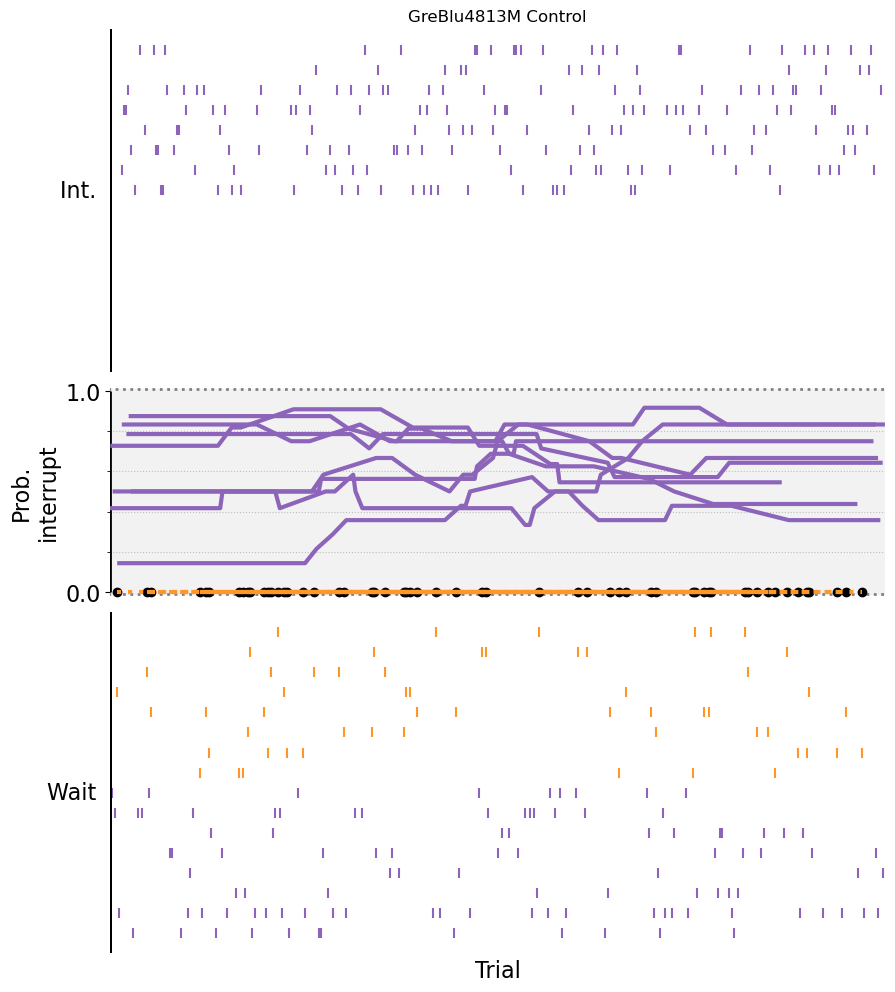

GreBlu4813M  Control: 
	 Groups: 16 dict_keys([('Rewarded', 'BlaBla0506', 'TH'), ('Rewarded', 'GraGra0201', 'TH'), ('Rewarded', 'GreOra1817', 'TH'), ('Rewarded', 'HPiHPi4748', 'TH'), ('Rewarded', 'LblRed0613', 'TH'), ('Rewarded', 'Unknown000', 'TH'), ('Rewarded', 'WhiBlu4818', 'TH'), ('Rewarded', 'WhiBlu5698', 'TH'), ('Unrewarded', 'BlaLbl8026', 'TE'), ('Unrewarded', 'GreOra1817', 'TE'), ('Unrewarded', 'GreWhi1242', 'TE'), ('Unrewarded', 'LblRed0613', 'TE'), ('Unrewarded', 'PurRas20dd', 'TE'), ('Unrewarded', 'WhiBlu4818', 'TE'), ('Unrewarded', 'WhiBlu5698', 'TE'), ('Unrewarded', 'WhiLbl0010', 'TE')])


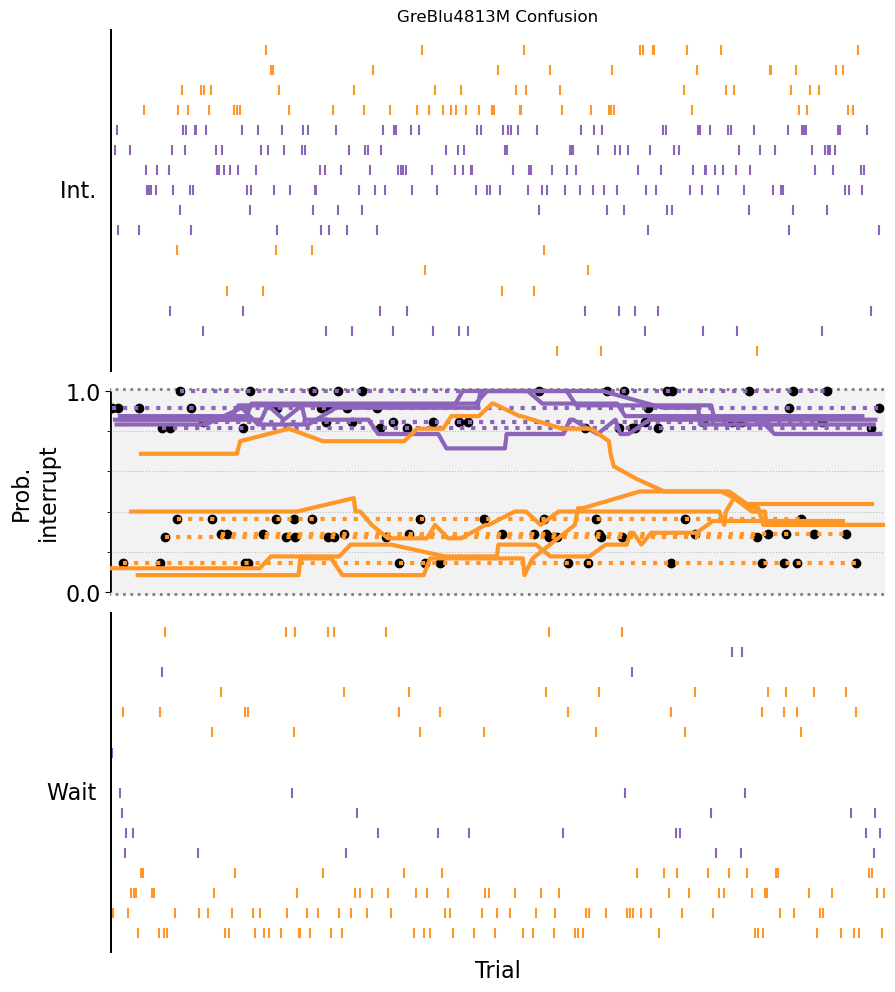

GreBlu4813M  Confusion: 
	 Groups: 16 dict_keys([('Rewarded', 'BlaBla0506', 'TH'), ('Rewarded', 'BluRas07dd', 'TE'), ('Rewarded', 'GraGra0201', 'TE'), ('Rewarded', 'GraGra0201', 'TH'), ('Rewarded', 'GreOra1817', 'TH'), ('Rewarded', 'HPiHPi4748', 'TH'), ('Rewarded', 'WhiGra0114', 'TE'), ('Rewarded', 'WhiWhi1415', 'TE'), ('Unrewarded', 'GreWhi1242', 'TE'), ('Unrewarded', 'LblRed0613', 'TE'), ('Unrewarded', 'PurRas20dd', 'TE'), ('Unrewarded', 'WhiBlu4818', 'TE'), ('Unrewarded', 'WhiBlu4917', 'TH'), ('Unrewarded', 'WhiGra0114', 'TH'), ('Unrewarded', 'WhiRas44dd', 'TH'), ('Unrewarded', 'WhiWhi1415', 'TH')])


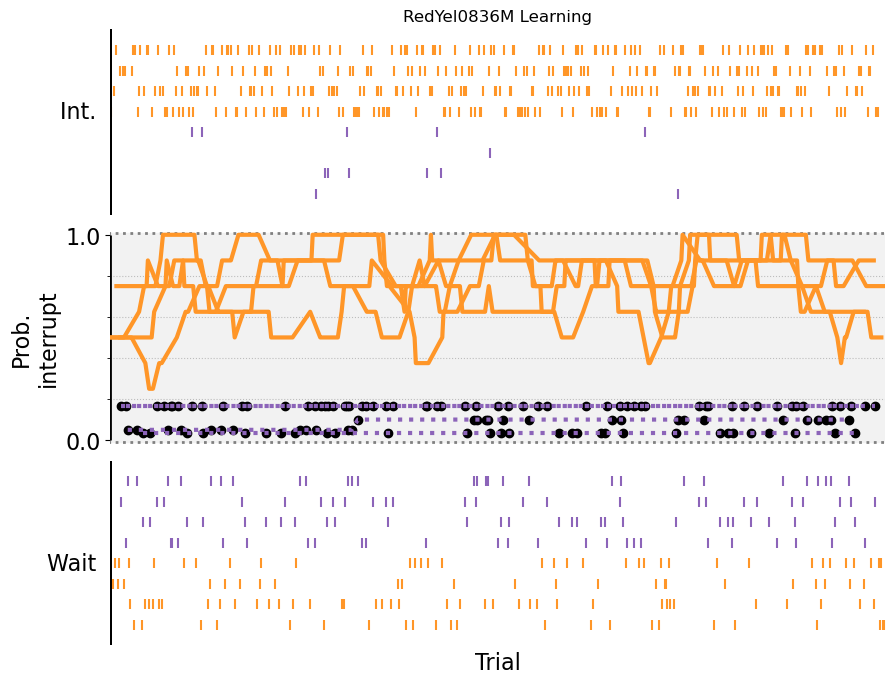

RedYel0836M  Learning: 
	 Groups: 8 dict_keys([('Rewarded', 'GreWhi1242', 'TE'), ('Rewarded', 'LblRed0613', 'TE'), ('Rewarded', 'PurRas20dd', 'TE'), ('Rewarded', 'WhiBlu4818', 'TE'), ('Unrewarded', 'BlaBla0506', 'TH'), ('Unrewarded', 'GraGra0201', 'TH'), ('Unrewarded', 'GreOra1817', 'TH'), ('Unrewarded', 'HPiHPi4748', 'TH')])


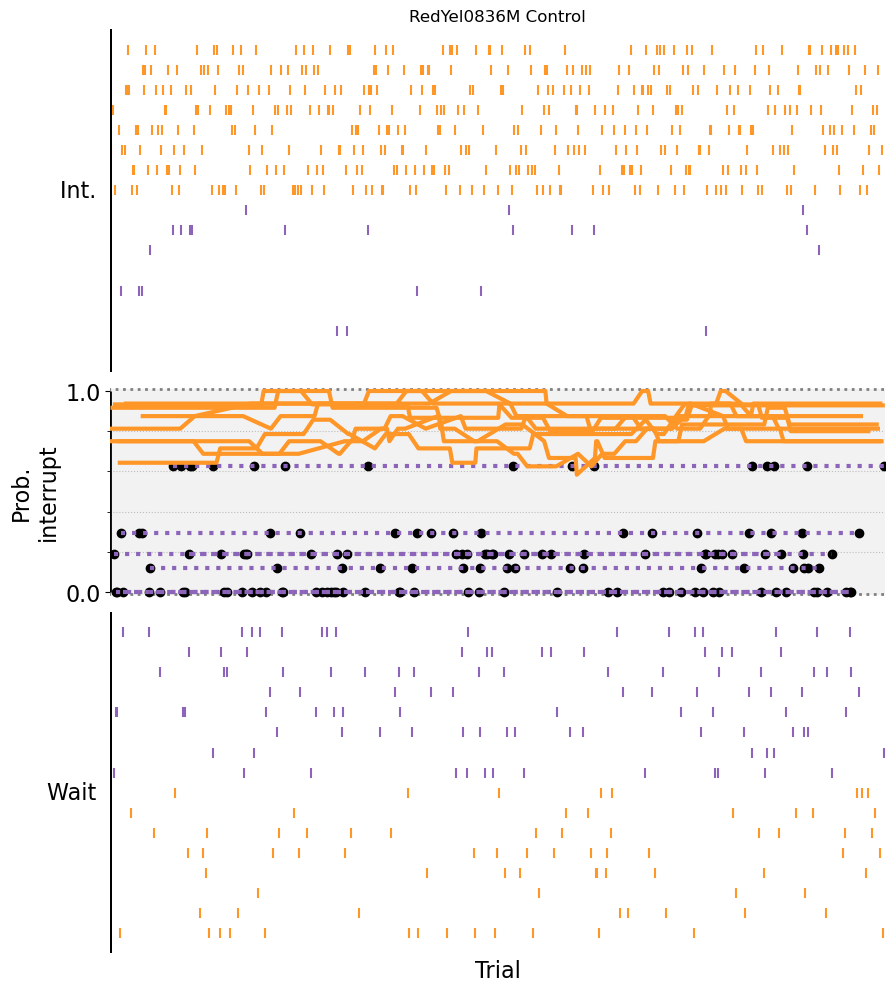

RedYel0836M  Control: 
	 Groups: 16 dict_keys([('Rewarded', 'BlaLbl8026', 'TE'), ('Rewarded', 'GreOra1817', 'TE'), ('Rewarded', 'GreWhi1242', 'TE'), ('Rewarded', 'LblRed0613', 'TE'), ('Rewarded', 'PurRas20dd', 'TE'), ('Rewarded', 'WhiBlu4818', 'TE'), ('Rewarded', 'WhiBlu5698', 'TE'), ('Rewarded', 'WhiLbl0010', 'TE'), ('Unrewarded', 'BlaBla0506', 'TH'), ('Unrewarded', 'GraGra0201', 'TH'), ('Unrewarded', 'GreOra1817', 'TH'), ('Unrewarded', 'HPiHPi4748', 'TH'), ('Unrewarded', 'LblRed0613', 'TH'), ('Unrewarded', 'Unknown000', 'TH'), ('Unrewarded', 'WhiBlu4818', 'TH'), ('Unrewarded', 'WhiBlu5698', 'TH')])


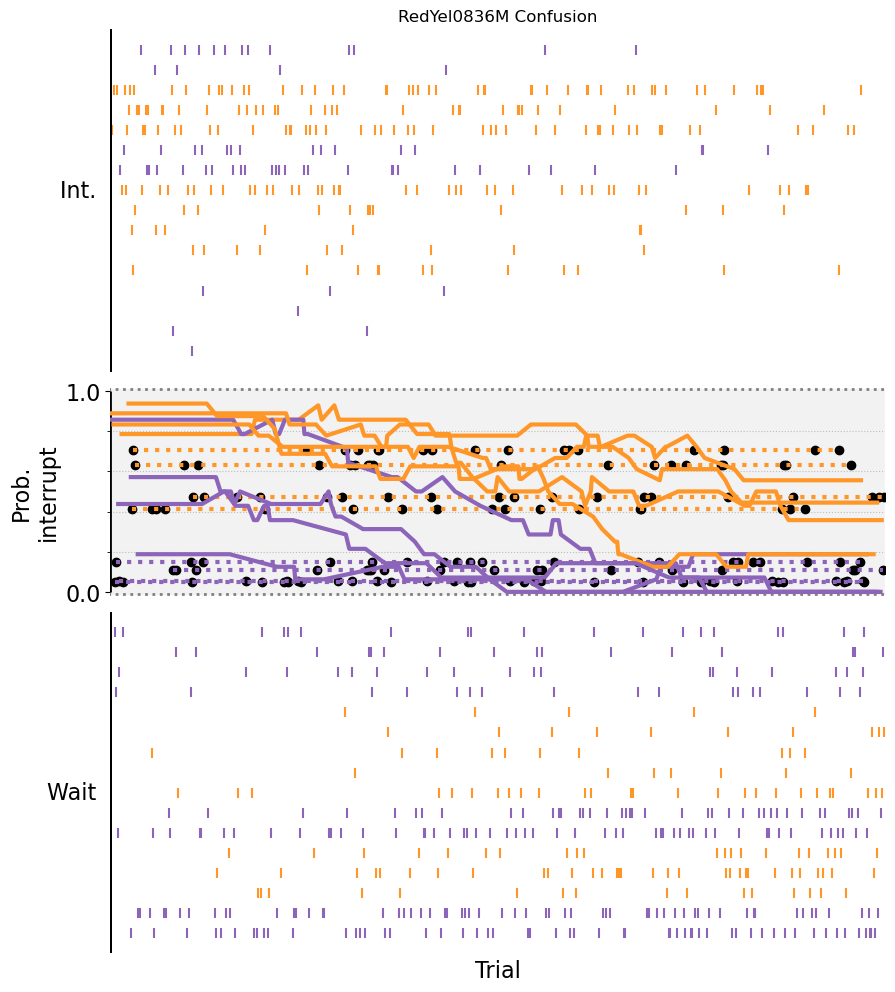

RedYel0836M  Confusion: 
	 Groups: 16 dict_keys([('Rewarded', 'GreWhi1242', 'TE'), ('Rewarded', 'LblRed0613', 'TE'), ('Rewarded', 'PurRas20dd', 'TE'), ('Rewarded', 'WhiBlu4818', 'TE'), ('Rewarded', 'WhiBlu4917', 'TH'), ('Rewarded', 'WhiGra0114', 'TH'), ('Rewarded', 'WhiRas44dd', 'TH'), ('Rewarded', 'WhiWhi1415', 'TH'), ('Unrewarded', 'BlaBla0506', 'TH'), ('Unrewarded', 'BluRas07dd', 'TE'), ('Unrewarded', 'GraGra0201', 'TE'), ('Unrewarded', 'GraGra0201', 'TH'), ('Unrewarded', 'GreOra1817', 'TH'), ('Unrewarded', 'HPiHPi4748', 'TH'), ('Unrewarded', 'WhiGra0114', 'TE'), ('Unrewarded', 'WhiWhi1415', 'TE')])


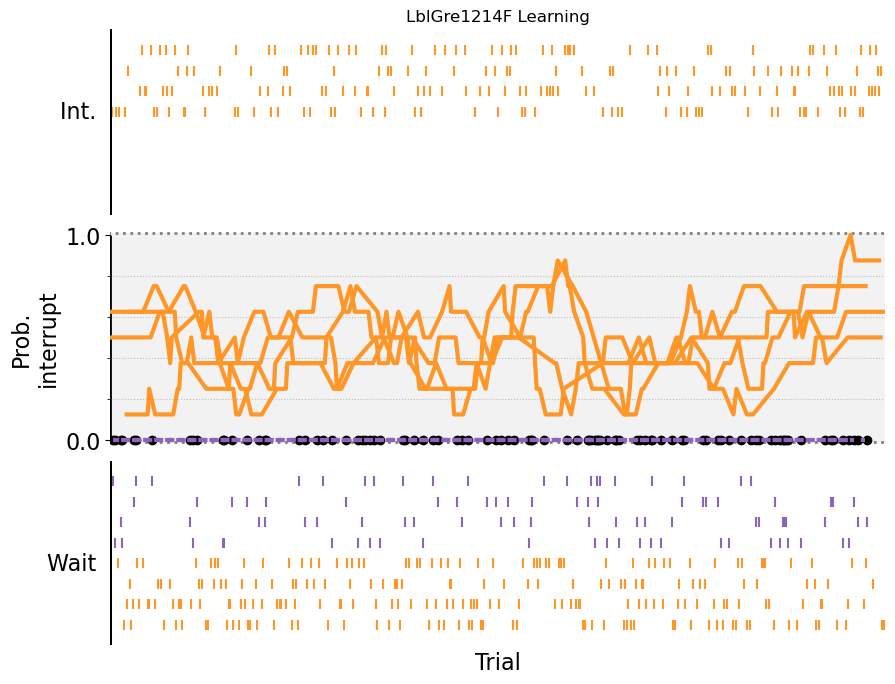

LblGre1214F  Learning: 
	 Groups: 8 dict_keys([('Rewarded', 'GreWhi1242', 'TE'), ('Rewarded', 'LblRed0613', 'TE'), ('Rewarded', 'PurRas20dd', 'TE'), ('Rewarded', 'WhiBlu4818', 'TE'), ('Unrewarded', 'BlaBla0506', 'TH'), ('Unrewarded', 'GraGra0201', 'TH'), ('Unrewarded', 'GreOra1817', 'TH'), ('Unrewarded', 'HPiHPi4748', 'TH')])


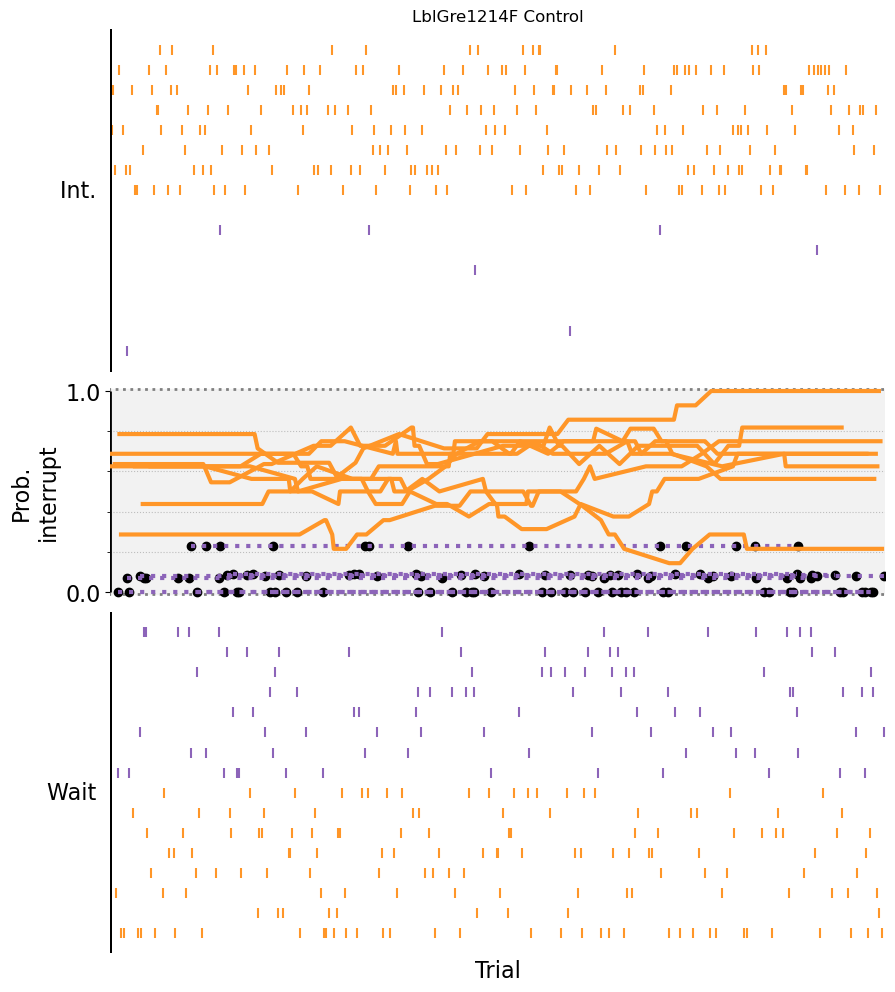

LblGre1214F  Control: 
	 Groups: 16 dict_keys([('Rewarded', 'BlaLbl8026', 'TE'), ('Rewarded', 'GreOra1817', 'TE'), ('Rewarded', 'GreWhi1242', 'TE'), ('Rewarded', 'LblRed0613', 'TE'), ('Rewarded', 'PurRas20dd', 'TE'), ('Rewarded', 'WhiBlu4818', 'TE'), ('Rewarded', 'WhiBlu5698', 'TE'), ('Rewarded', 'WhiLbl0010', 'TE'), ('Unrewarded', 'BlaBla0506', 'TH'), ('Unrewarded', 'GraGra0201', 'TH'), ('Unrewarded', 'GreOra1817', 'TH'), ('Unrewarded', 'HPiHPi4748', 'TH'), ('Unrewarded', 'LblRed0613', 'TH'), ('Unrewarded', 'Unknown000', 'TH'), ('Unrewarded', 'WhiBlu4818', 'TH'), ('Unrewarded', 'WhiBlu5698', 'TH')])


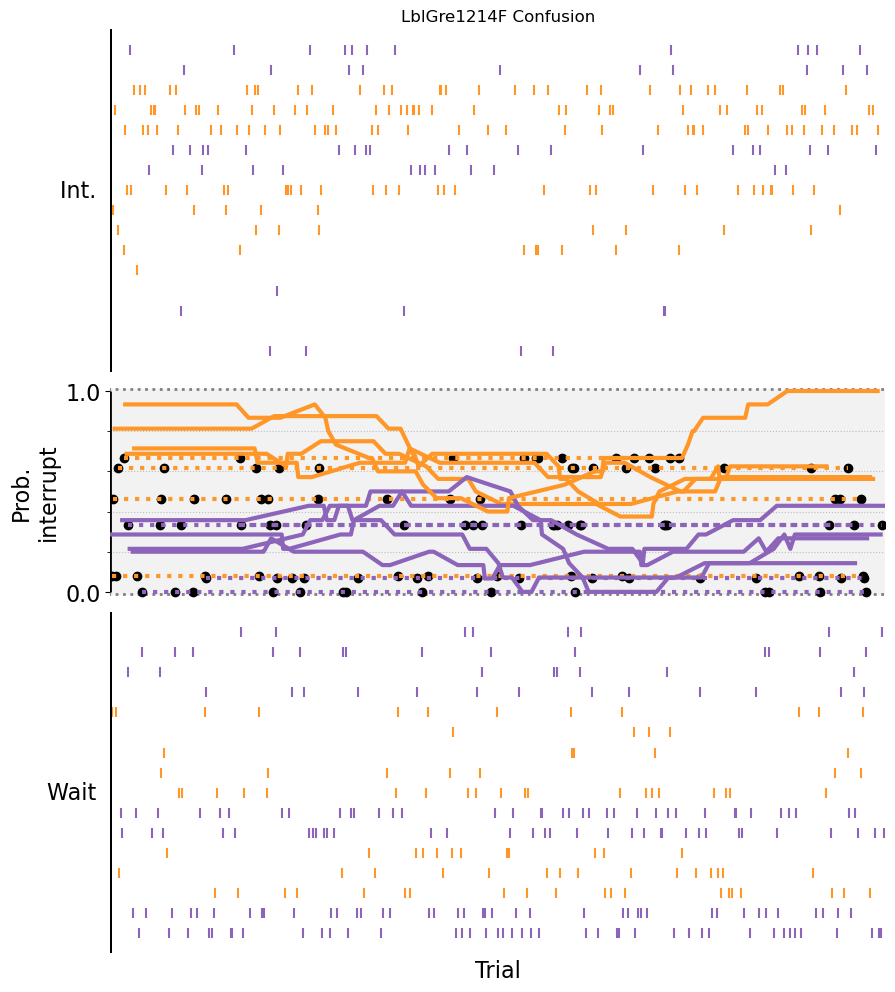

LblGre1214F  Confusion: 
	 Groups: 16 dict_keys([('Rewarded', 'GreWhi1242', 'TE'), ('Rewarded', 'LblRed0613', 'TE'), ('Rewarded', 'PurRas20dd', 'TE'), ('Rewarded', 'WhiBlu4818', 'TE'), ('Rewarded', 'WhiBlu4917', 'TH'), ('Rewarded', 'WhiGra0114', 'TH'), ('Rewarded', 'WhiRas44dd', 'TH'), ('Rewarded', 'WhiWhi1415', 'TH'), ('Unrewarded', 'BlaBla0506', 'TH'), ('Unrewarded', 'BluRas07dd', 'TE'), ('Unrewarded', 'GraGra0201', 'TE'), ('Unrewarded', 'GraGra0201', 'TH'), ('Unrewarded', 'GreOra1817', 'TH'), ('Unrewarded', 'HPiHPi4748', 'TH'), ('Unrewarded', 'WhiGra0114', 'TE'), ('Unrewarded', 'WhiWhi1415', 'TE')])


In [9]:
example_subject = "GreBlu4813M"   # all are good.. 
grouping = ["condition_name", "Stimulus Vocalizer", "Stimulus Call Type"]

for example_subject in birds:
    # 4 v 4 day 
    subject_df = learning_df[learning_df["bird"] == example_subject]
    fig = plot_data(subject_df, grouping)
    plt.title(example_subject + " Learning")
    plt.show()
    fig.savefig(FIGDIR+example_subject+'_learning.svg', format="svg", bbox_inches="tight")
    plt.close(fig)
    dfGrouped = subject_df.groupby(grouping)
    print( example_subject, " Learning: ")  
    print('\t Groups:', len(dfGrouped.groups.keys()), dfGrouped.groups.keys() )

    # 8v8 control day
    subject_df = control_df[control_df["bird"] == example_subject]
    fig = plot_data(subject_df, grouping)
    plt.title(example_subject + " Control")
    plt.show()
    fig.savefig(FIGDIR+example_subject+'_control.svg', format="svg", bbox_inches="tight")
    plt.close(fig)
    dfGrouped = subject_df.groupby(grouping)
    print( example_subject, " Control: ")  
    print('\t Groups:', len(dfGrouped.groups.keys()), dfGrouped.groups.keys() )


    subject_df = confusing_df[confusing_df["bird"] == example_subject]
    fig = plot_data(subject_df, grouping)
    plt.title(example_subject + " Confusion")
    plt.show()
    fig.savefig(FIGDIR+example_subject+'_confusing.svg', format="svg", bbox_inches="tight")
    plt.close(fig)
    dfGrouped = subject_df.groupby(grouping)
    print( example_subject, " Confusion: ")  
    print('\t Groups:', len(dfGrouped.groups.keys()), dfGrouped.groups.keys() )


